<a href="https://colab.research.google.com/github/Rishav273/ineruon_keras_tuner_classifier/blob/branch_1/Ineuron_image_classification_Keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner
!pip install split-folders

In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import splitfolders
from tqdm import tqdm
import matplotlib.pyplot as plt

# model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras_tuner.tuners import RandomSearch

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Split data into training and validation data
splitfolders.ratio(input=r"/content/drive/MyDrive/dataset",
                   output="img_clf_dataset",
                   seed=1337,
                   ratio=(.8, .1, .1)
                   )

Copying files: 712 files [03:18,  3.58 files/s]


In [ ]:
class_names = ['cat', 'dog', 'lion', 'deer', 'elephant']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = 150


In [ ]:
# batch size
BS = 32

In [ ]:
TRAIN_DIR = "/content/img_clf_dataset/train"
TEST_DIR = "/content/img_clf_dataset/test"
VAL_DIR = "/content/img_clf_dataset/val"

In [ ]:
def load_dataset():

    TRAIN_DIR = "/content/img_clf_dataset/train"
    TEST_DIR = "/content/img_clf_dataset/test"
    VAL_DIR = "/content/img_clf_dataset/val"

    datasets = [TRAIN_DIR, TEST_DIR,VAL_DIR]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE)) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels), (val_images,val_labels) = load_dataset()

Loading /content/img_clf_dataset/train


100%|██████████| 112/112 [00:00<00:00, 202.39it/s]


Loading /content/img_clf_dataset/test


100%|██████████| 15/15 [00:00<00:00, 306.03it/s]


Loading /content/img_clf_dataset/val


100%|██████████| 14/14 [00:00<00:00, 269.34it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [ ]:
train_images[0]

array([[[250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.],
        ...,
        [250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.]],

       [[250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.],
        ...,
        [250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.]],

       [[250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.],
        ...,
        [250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.]],

       ...,

       [[250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.],
        ...,
        [250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.]],

       [[250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.],
        ...,
        [250., 250., 250.],
        [250., 250., 250.],
        [250., 250., 250.]],

       [[250., 250., 250.],
        [250., 250., 250.],
        [250., 2

## The collected dataset is more or less balanced

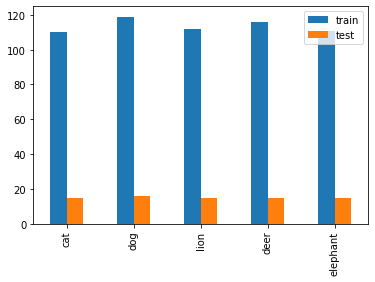

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

## Normalizing pixel values

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
val_images = val_images / 255.0

In [ ]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

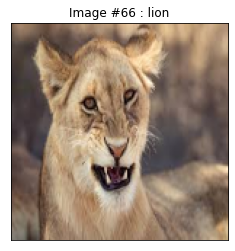

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
# baseline architecture
nn_model = Sequential()
nn_model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
nn_model.add(MaxPool2D(pool_size=(2,2)))
nn_model.add(Conv2D(filters=64,kernel_size=(3,3)))
nn_model.add(MaxPool2D(pool_size=(2,2)))
nn_model.add(Flatten())
nn_model.add(Dense(64,activation="relu"))
nn_model.add(Dense(5,activation="softmax"))

nn_model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [ ]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5308480   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [ ]:
history = nn_model.fit(train_images,train_labels,epochs=30,batch_size=BS,validation_data=(val_images,val_labels))

Epoch 1/30
18/18 [==============================] - 3s 76ms/step - loss: 4.6257 - accuracy: 0.2465 - val_loss: 1.7025 - val_accuracy: 0.3235
Epoch 2/30
18/18 [==============================] - 1s 42ms/step - loss: 1.4737 - accuracy: 0.3820 - val_loss: 1.5380 - val_accuracy: 0.3824
Epoch 3/30
18/18 [==============================] - 1s 41ms/step - loss: 1.3889 - accuracy: 0.4137 - val_loss: 1.4520 - val_accuracy: 0.3824
Epoch 4/30
18/18 [==============================] - 1s 42ms/step - loss: 1.2267 - accuracy: 0.5405 - val_loss: 1.3864 - val_accuracy: 0.4706
Epoch 5/30
18/18 [==============================] - 1s 42ms/step - loss: 1.1629 - accuracy: 0.5581 - val_loss: 1.4657 - val_accuracy: 0.4706
Epoch 6/30
18/18 [==============================] - 1s 44ms/step - loss: 1.0257 - accuracy: 0.6197 - val_loss: 1.4389 - val_accuracy: 0.4265
Epoch 7/30
18/18 [==============================] - 1s 42ms/step - loss: 0.9181 - accuracy: 0.6866 - val_loss: 1.5190 - val_accuracy: 0.4265
Epoch 8/30
18

## Hyperparameter tuning

In [ ]:
# model building function

def build_nn(hp):

  model = Sequential()
  model.add(Conv2D(filters=hp.Int("Conv1",min_value=32, max_value=96, step=32),
                    kernel_size=hp.Choice("Conv1",values=[3,6]),padding="same",
                    activation="relu",
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(filters=hp.Int("Conv2",min_value=64, max_value=96, step=32),
                    kernel_size=hp.Choice("Conv2",values=[3,6]),padding="same",
                    activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2)))  
  model.add(Flatten())
  model.add(Dense(64,activation="relu"))
  model.add(Dense(5,activation="softmax"))

  # compile
  learning_rate = hp.Choice("Learning rate",values=[1e-3,1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  return model

In [ ]:
# Instantiate randomSearch tuner
tuner = RandomSearch(build_nn,
                   objective="val_accuracy",
                   overwrite=False,
                   max_trials=2,
                   executions_per_trial=1,
                   directory="output",
                   project_name="img_classifier"
                   )

INFO:tensorflow:Reloading Oracle from existing project output/img_classifier/oracle.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
Conv1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': None}
Conv2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 96, 'step': 32, 'sampling': None}
Learning rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

Trial 2 Complete [00h 03m 33s]
val_accuracy: 0.20588235557079315

Best val_accuracy So Far: 0.20588235557079315
Total elapsed time: 01h 18m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
# make predicions using best model
predictions = np.argmax(best_model.predict(test_images),axis=1)